<a href="https://colab.research.google.com/github/rohinishimpatwar/DeepLearning/blob/master/Assignment4-DeepLearning/LSTM_and_CONV1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**LSTM on Stock prices** 

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!ls /content/drive/'My Drive'/DeepLearningSem3/input

'Copy of labels.csv'	        ge.us.txt
 dog-breed-identification.zip   __MACOSX
 dogs-breed		        sample_submission.csv
 dogs-breed-identification      stockiter1dropout_layers_0.4_0.4
 dogs-vs-cats		        stockiterdropout_layers_0.4_0.4
 dogs-vs-cats.zip	        test.zip
 ge-stock.zip		        train.zip


In [0]:
import pandas as pd
import os
df_ge = pd.read_csv("/content/drive/My Drive/DeepLearningSem3/input/ge.us.txt")
df_ge.tail()

,Date,Open,High,Low,Close,Volume,OpenInt
14053,2017-11-06,20.52,20.530,20.08,20.13,60641787,0
14054,2017-11-07,20.17,20.250,20.12,20.21,41622851,0
14055,2017-11-08,20.21,20.320,20.07,20.12,39672190,0
14056,2017-11-09,20.04,20.071,19.85,19.99,50831779,0
14057,2017-11-10,19.98,20.680,19.90,20.49,100698474,0


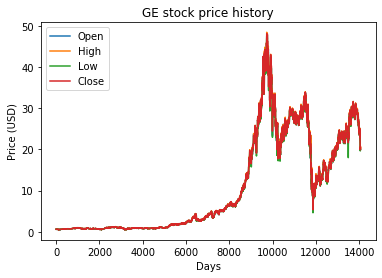

In [0]:
from matplotlib import pyplot as plt
plt.figure()
plt.plot(df_ge["Open"])
plt.plot(df_ge["High"])
plt.plot(df_ge["Low"])
plt.plot(df_ge["Close"])
plt.title('GE stock price history')
plt.ylabel('Price (USD)')
plt.xlabel('Days')
plt.legend(['Open','High','Low','Close'], loc='upper left')
plt.show()

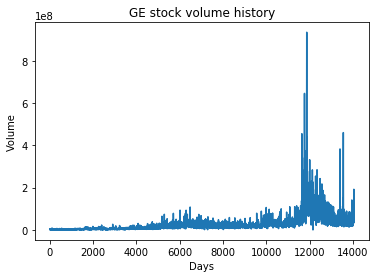

In [0]:
plt.figure()
plt.plot(df_ge["Volume"])
plt.title('GE stock volume history')
plt.ylabel('Volume')
plt.xlabel('Days')
plt.show()

In [0]:
print("checking if any null values are present\n", df_ge.isna().sum())

checking if any null values are present
 Date       0
Open       0
High       0
Low        0
Close      0
Volume     0
OpenInt    0
dtype: int64


In [0]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

train_cols = ["Open","High","Low","Close","Volume"]
df_train, df_test = train_test_split(df_ge, train_size=0.8, test_size=0.2, shuffle=False)
print("Train and Test size", len(df_train), len(df_test))
# scale the feature MinMax, build array
x = df_train.loc[:,train_cols].values
min_max_scaler = MinMaxScaler()
x_train = min_max_scaler.fit_transform(x)
x_test = min_max_scaler.transform(df_test.loc[:,train_cols])

Train and Test size 11246 2812


In [0]:
def build_timeseries(mat, y_col_index):
    # y_col_index is the index of column that would act as output column
    # total number of time-series samples would be len(mat) - TIME_STEPS
    dim_0 = mat.shape[0] - TIME_STEPS
    dim_1 = mat.shape[1]
    x = np.zeros((dim_0, TIME_STEPS, dim_1))
    y = np.zeros((dim_0,))
    
    for i in tqdm_notebook(range(dim_0)):
        x[i] = mat[i:TIME_STEPS+i]
        y[i] = mat[TIME_STEPS+i, y_col_index]
    print("length of time-series i/o",x.shape,y.shape)
    return x, y

In [0]:
def trim_dataset(mat, batch_size):
    """
    trims dataset to a size that's divisible by BATCH_SIZE
    """
    no_of_rows_drop = mat.shape[0]%batch_size
    if(no_of_rows_drop > 0):
        return mat[:-no_of_rows_drop]
    else:
        return mat

In [0]:
import numpy as np
import os
import sys
import time
import pandas as pd 
from tqdm._tqdm_notebook import tqdm_notebook
import pickle
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from keras import optimizers
# from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import logging
# import talos as ta

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
logging.getLogger("tensorflow").setLevel(logging.ERROR)
os.environ['TZ'] = 'Asia/Kolkata'  # to set timezone; needed when running on cloud
time.tzset()




Using TensorFlow backend.


In [0]:
params = {
    "batch_size": 20,  # 20<16<10, 25 was a bust
    "epochs": 5,
    "lr": 0.00010000,
    "time_steps": 60
}
iter_changes = "dropout_layers_0.4_0.4"

INPUT_PATH = "/content/drive/My Drive/DeepLearningSem3/input/ge.us.txt"
OUTPUT_PATH = "/content/drive/My Drive/DeepLearningSem3/input/stockiter1"+iter_changes
TIME_STEPS = params["time_steps"]
BATCH_SIZE = params["batch_size"]

x_t, y_t = build_timeseries(x_train, 3)
x_t = trim_dataset(x_t, BATCH_SIZE)
y_t = trim_dataset(y_t, BATCH_SIZE)
print("Batch trimmed size",x_t.shape, y_t.shape)





length of time-series i/o (11186, 60, 5) (11186,)
Batch trimmed size (11180, 60, 5) (11180,)


In [0]:
def create_model():
    lstm_model = Sequential()
    # (batch_size, timesteps, data_dim)
    lstm_model.add(LSTM(100, batch_input_shape=(BATCH_SIZE, TIME_STEPS, x_t.shape[2]),
                        dropout=0.0, recurrent_dropout=0.0, stateful=True, return_sequences=True,
                        kernel_initializer='random_uniform'))
    lstm_model.add(Dropout(0.4))
    lstm_model.add(LSTM(60, dropout=0.0))
    lstm_model.add(Dropout(0.4))
    lstm_model.add(Dense(20,activation='relu'))
    lstm_model.add(Dense(1,activation='sigmoid'))
    optimizer = optimizers.RMSprop(lr=params["lr"])
    # optimizer = optimizers.SGD(lr=0.000001, decay=1e-6, momentum=0.9, nesterov=True)
    lstm_model.compile(loss='mean_squared_error', optimizer=optimizer)
    return lstm_model

In [0]:
model = None
try:
    model = pickle.load(open("lstm_model", 'rb'))
    print("Loaded saved model...")
except FileNotFoundError:
    print("Model not found")


x_temp, y_temp = build_timeseries(x_test, 3)
x_val, x_test_t = np.split(trim_dataset(x_temp, BATCH_SIZE),2)
y_val, y_test_t = np.split(trim_dataset(y_temp, BATCH_SIZE),2)

print("Test size", x_test_t.shape, y_test_t.shape, x_val.shape, y_val.shape)
    
is_update_model = True
if model is None or is_update_model:
    from keras import backend as K
    print("Building model...")
    print("checking if GPU available", K.tensorflow_backend._get_available_gpus())
    model = create_model()
    
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,
                       patience=40, min_delta=0.0001)
    
    mcp = ModelCheckpoint(os.path.join(OUTPUT_PATH,
                          "best_model.h5"), monitor='val_loss', verbose=1,
                          save_best_only=True, save_weights_only=False, mode='min', period=1)

    # Not used here. But leaving it here as a reminder for future
    r_lr_plat = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=30, 
                                  verbose=0, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
    
    csv_logger = CSVLogger(os.path.join(OUTPUT_PATH, 'training_log_' + time.ctime().replace(" ","_") + '.log'), append=True)
    
    history = model.fit(x_t, y_t, epochs=params["epochs"], verbose=2, batch_size=BATCH_SIZE,
                        shuffle=False, validation_data=(trim_dataset(x_val, BATCH_SIZE),
                        trim_dataset(y_val, BATCH_SIZE)), callbacks=[es, mcp, csv_logger])
    
    print("saving model...")
    pickle.dump(model, open("lstm_model", "wb"))

Model not found



length of time-series i/o (2752, 60, 5) (2752,)
Test size (1370, 60, 5) (1370,) (1370, 60, 5) (1370,)
Building model...
checking if GPU available []
Train on 11180 samples, validate on 1360 samples
Epoch 1/5
 - 39s - loss: 0.0219 - val_loss: 0.0199

Epoch 00001: val_loss improved from inf to 0.01988, saving model to /content/drive/My Drive/DeepLearningSem3/input/stockiter1dropout_layers_0.4_0.4/best_model.h5
Epoch 2/5
 - 39s - loss: 0.0044 - val_loss: 0.0042

Epoch 00002: val_loss improved from 0.01988 to 0.00424, saving model to /content/drive/My Drive/DeepLearningSem3/input/stockiter1dropout_layers_0.4_0.4/best_model.h5
Epoch 3/5
 - 39s - loss: 0.0017 - val_loss: 0.0033

Epoch 00003: val_loss improved from 0.00424 to 0.00328, saving model to /content/drive/My Drive/DeepLearningSem3/input/stockiter1dropout_layers_0.4_0.4/best_model.h5
Epoch 4/5
 - 39s - loss: 0.0016 - val_loss: 0.0035

Epoch 00004: val_loss did not improve from 0.00328
Epoch 5/5
 - 39s - loss: 0.0013 - val_loss: 0.00

Error is 0.0023963142593643777 (1360,) (1360,)
[0.3675004  0.36707664 0.36669266 0.36617315 0.36553147 0.3647328
 0.36449328 0.36441827 0.36458683 0.3646869  0.36491063 0.3657208
 0.36441275 0.3635817  0.3619734 ]
[0.32378063 0.32499919 0.32800358 0.32905407 0.32905407 0.33031465
 0.32943225 0.33205846 0.32659593 0.32747834 0.31770881 0.31092267
 0.31258244 0.32378063 0.32592362]
[17.95093  17.93076  17.912485 17.887756 17.857216 17.8192   17.8078
 17.80423  17.812254 17.817017 17.827665 17.866226 17.803968 17.764412
 17.687862]
[15.87  15.928 16.071 16.121 16.121 16.181 16.139 16.264 16.004 16.046
 15.581 15.258 15.337 15.87  15.972]
Error is 0.002401614318355955 (1360,) (1360,)
[0.3729862  0.37251323 0.37181556 0.37110743 0.37058455 0.36969626
 0.36924565 0.36912796 0.36913884 0.3691284  0.3692202  0.37008536
 0.36905688 0.36831474 0.36674935]
[0.32378063 0.32499919 0.32800358 0.32905407 0.32905407 0.33031465
 0.32943225 0.33205846 0.32659593 0.32747834 0.31770881 0.31092267
 0.31258

NameError: ignored

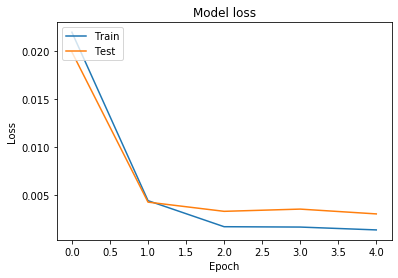

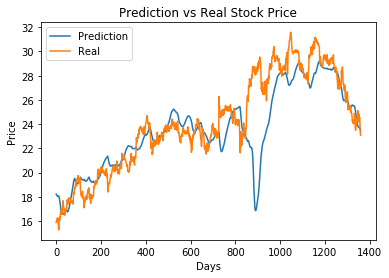

In [0]:
# model.evaluate(x_test_t, y_test_t, batch_size=BATCH_SIZE
y_pred = model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)
print("Error is", error, y_pred.shape, y_test_t.shape)
print(y_pred[0:15])
print(y_test_t[0:15])

# convert the predicted value to range of real data
y_pred_org = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
# min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3]
# min_max_scaler.inverse_transform(y_test_t)
print(y_pred_org[0:15])
print(y_test_t_org[0:15])

# Visualize the training data
from matplotlib import pyplot as plt
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
#plt.show()
plt.savefig(os.path.join(OUTPUT_PATH, 'train_vis_BS_'+str(BATCH_SIZE)+"_"+time.ctime()+'.png'))

# load the saved best model from above
saved_model = load_model(os.path.join(OUTPUT_PATH, 'best_model.h5')) # , "lstm_best_7-3-19_12AM",
print(saved_model)

y_pred = saved_model.predict(trim_dataset(x_test_t, BATCH_SIZE), batch_size=BATCH_SIZE)
y_pred = y_pred.flatten()
y_test_t = trim_dataset(y_test_t, BATCH_SIZE)
error = mean_squared_error(y_test_t, y_pred)
print("Error is", error, y_pred.shape, y_test_t.shape)
print(y_pred[0:15])
print(y_test_t[0:15])
y_pred_org = (y_pred * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] # min_max_scaler.inverse_transform(y_pred)
y_test_t_org = (y_test_t * min_max_scaler.data_range_[3]) + min_max_scaler.data_min_[3] # min_max_scaler.inverse_transform(y_test_t)
print(y_pred_org[0:15])
print(y_test_t_org[0:15])

# Visualize the prediction
from matplotlib import pyplot as plt
plt.figure()
plt.plot(y_pred_org)
plt.plot(y_test_t_org)
plt.title('Prediction vs Real Stock Price')
plt.ylabel('Price')
plt.xlabel('Days')
plt.legend(['Prediction', 'Real'], loc='upper left')
#plt.show()
plt.savefig(os.path.join(OUTPUT_PATH, 'pred_vs_real_BS'+str(BATCH_SIZE)+"_"+time.ctime()+'.png'))
print_time("program completed ", stime)